In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Epipolar Geometry

## Reading a pair of images, and comparing SIFT matches

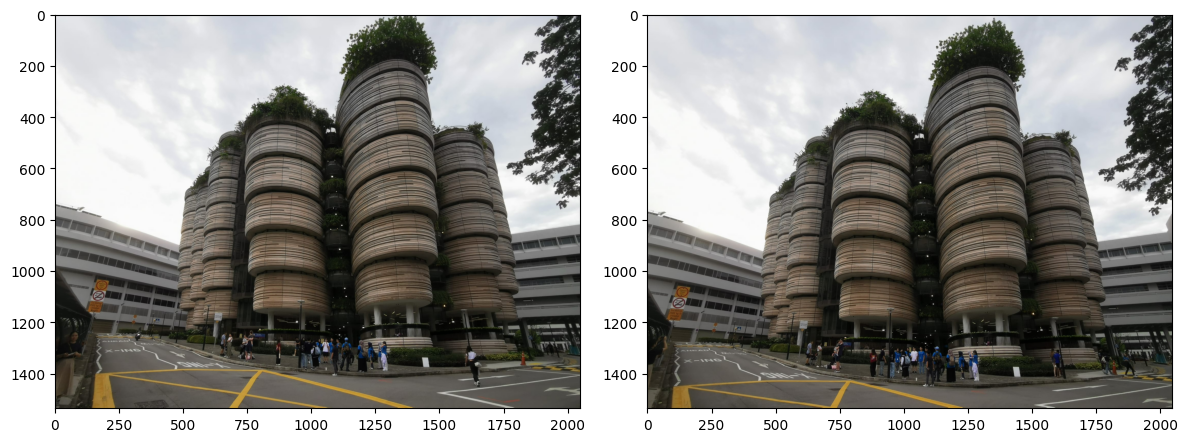

In [ ]:
import cv2
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
# Reading two images for reference
# img1 = cv2.imread('/content/drive/MyDrive/Structure4/t04.jpeg')
# img2 = cv2.imread('/content/drive/MyDrive/Structure4/t05.jpeg')
img1 = cv2.imread('/content/drive/MyDrive/Structure7/01.jpeg')
img2 = cv2.imread('/content/drive/MyDrive/Structure7/02.jpeg')


# Check if images are loaded
if img1 is None:
    print("Image 1 not loaded. Check the file path.")
if img2 is None:
    print("Image 2 not loaded. Check the file path.")

# Proceed only if images are loaded
if img1 is not None and img2 is not None:

    # Convert from BGR to RGB format for displaying with matplotlib
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Adjust the figure size
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display Original Image
    ax[0].imshow(img1)
    #ax[0].axis('off')  # Turn off axis

    # Display Equalized Image
    ax[1].imshow(img2)
    #ax[1].axis('off')  # Turn off axis

    # Show the figure
    plt.tight_layout()
    plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def GetImageMatches(img1,img2):
    surfer=cv2.SIFT_create()
    kp1, desc1 = surfer.detectAndCompute(img1,None)
    kp2, desc2 = surfer.detectAndCompute(img2,None)

    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(desc1, desc2)

    matches = sorted(matches, key = lambda x:x.distance)

    return kp1,desc1,kp2,desc2,matches

def GetAlignedMatches(kp1,desc1,kp2,desc2,matches):

    #Sorting in case matches array isn't already sorted
    matches = sorted(matches, key = lambda x:x.distance)

    #retrieving corresponding indices of keypoints (in both images) from matches.
    img1idx = np.array([m.queryIdx for m in matches])
    img2idx = np.array([m.trainIdx for m in matches])

    #filtering out the keypoints that were NOT matched.
    kp1_ = (np.array(kp1))[img1idx]
    kp2_ = (np.array(kp2))[img2idx]

    #retreiving the image coordinates of matched keypoints
    img1pts = np.array([kp.pt for kp in kp1_])
    img2pts = np.array([kp.pt for kp in kp2_])

    return img1pts,img2pts,img1idx,img2idx

#Getting SIFT/SURF features for image matching (this might take a while)
kp1,desc1,kp2,desc2,matches=GetImageMatches(img1,img2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=GetAlignedMatches(kp1,desc1,kp2,desc2,matches)

## Fundamental Matrix Computation

### Eight Point Algorithm

In [ ]:
def EstimateFundamentalMatrix(x1,x2):
    if x1.shape[1]==2: #converting to homogenous coordinates if not already
        x1 = cv2.convertPointsToHomogeneous(x1)[:,0,:]
        x2 = cv2.convertPointsToHomogeneous(x2)[:,0,:]

    A = np.zeros((x1.shape[0],9))

    #Constructing A matrix (vectorized)
    x1_ = x1.repeat(3,axis=1)
    x2_ = np.tile(x2, (1,3))

    A = x1_*x2_

    u,s,v = np.linalg.svd(A)
    F = v[-1,:].reshape((3,3),order='F')

    u,s,v = np.linalg.svd(F)
    F = u.dot(np.diag(s).dot(v))

    F = F / F[-1,-1]

    return F

img1pts_, img2pts_ = img1pts[:8], img2pts[:8]
Fgt, mask = cv2.findFundamentalMat(img1pts_,img2pts_,method=cv2.FM_8POINT)
F = EstimateFundamentalMatrix(img1pts_,img2pts_)

In [ ]:
print(F)
print(Fgt)
#np.testing.assert_allclose(F, Fgt, rtol=1e-7,atol=1e-3)

[[-8.75060245e-09 -3.21405582e-05  3.64969127e-02]
 [ 3.25122745e-05 -8.04184990e-07 -8.56543279e-04]
 [-3.79163895e-02  9.50692479e-04  1.00000000e+00]]
[[-1.71610486e-08 -3.23896395e-05  3.67915471e-02]
 [ 3.27705519e-05 -8.11677940e-07 -8.66312016e-04]
 [-3.82059807e-02  9.55110377e-04  1.00000000e+00]]


### with RANSAC (Random Sample Consensus)

In [ ]:
Fgt, maskgt = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,ransacReprojThreshold=.1)
maskgt = maskgt.astype(bool).flatten()
def SampsonError(F,x1,x2):
    num = np.sum(x1.dot(F) * x2,axis=-1)

    F_src = np.dot(F, x1.T)
    Ft_dst = np.dot(F.T, x2.T)

    dst_F_src = np.sum(x2 * F_src.T, axis=1)

    return np.abs(dst_F_src) / np.sqrt(F_src[0] ** 2 +
    F_src[1] ** 2 + Ft_dst[0] ** 2 + Ft_dst[1] ** 2)

def EstimateFundamentalMatrixRANSAC(img1pts,img2pts,outlierThres,prob=None,iters=None):
    if img1pts.shape[1]==2:
        #converting to homogenous coordinates if not already
        img1pts = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
        img2pts = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    bestInliers, bestF, bestmask = 0, None, None

    for i in range(iters):

        #Selecting 8 random points
        mask = np.random.randint(low=0,high=img1pts.shape[0],size=(8,))
        img1ptsiter = img1pts[mask]
        img2ptsiter = img2pts[mask]

        #Fitting fundamental matrix and evaluating error
        Fiter = EstimateFundamentalMatrix(img1ptsiter,img2ptsiter)
        err = SampsonError(Fiter,img1pts,img2pts)
        mask = err < outlierThres
        numInliers = np.sum(mask)

        #Updating best measurements if appropriate
        if bestInliers < numInliers:
            bestInliers = numInliers
            bestF = Fiter
            bestmask = mask

    #Final least squares fit on all inliers found..
    F = EstimateFundamentalMatrix(img1pts[bestmask], img2pts[bestmask])

    return F, bestmask

F, mask = EstimateFundamentalMatrixRANSAC(img1pts,img2pts,.1,iters=20000)

In [ ]:
print(Fgt)
print(F)
#np.testing.assert_allclose(F,Fgt,rtol=1e-7,atol=1e-3)

[[-6.00480221e-08 -3.72794391e-05  4.04582681e-02]
 [ 3.77022496e-05 -9.59961611e-07 -7.54854599e-04]
 [-4.19526723e-02  9.20703172e-04  1.00000000e+00]]
[[-2.53253557e-10 -3.56073123e-05  4.06249101e-02]
 [ 3.60553039e-05 -9.94685957e-07  6.82138937e-03]
 [-4.22949228e-02 -6.66210546e-03  1.00000000e+00]]


## Epipolar Lines Computation

In [ ]:
def ComputeEpiline(pts, index, F):
    """
    pts: (n,3) points matrix

    lines: (n,3) lines matrix"""

    if pts.shape[1]==2:
        #converting to homogenous coordinates if not already
        pts = cv2.convertPointsToHomogeneous(pts)[:,0,:]

    if index==1:
        lines = F.dot(pts.T)
    elif index==2:
        lines = F.T.dot(pts.T)

    return lines.T

lines2=ComputeEpiline(img1pts[mask],1,F)
lines1=ComputeEpiline(img2pts[mask],2,F)

## Visualizations: Epipolar Geometry
### Epipolar Lines

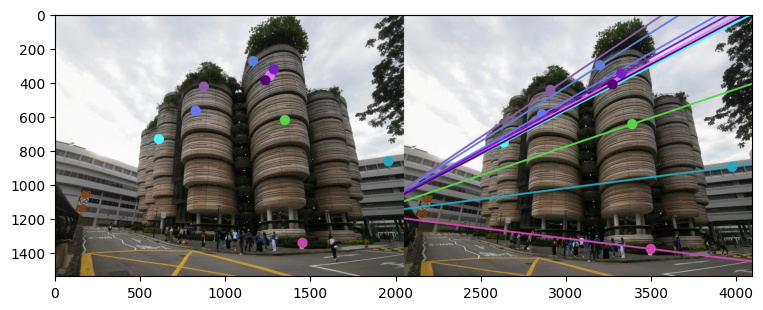

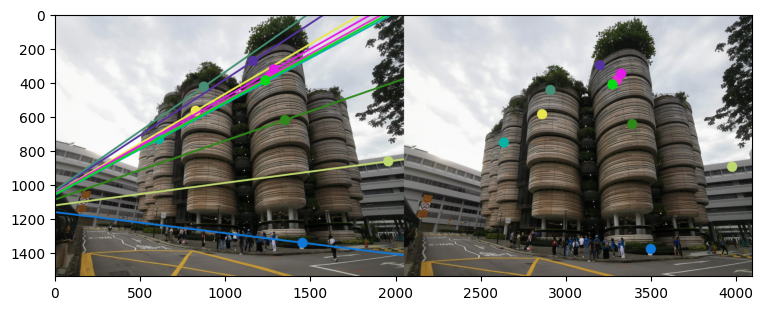

In [ ]:
def drawlines(img1,img2,lines,pts1,pts2,drawOnly=None,linesize=3,circlesize=10):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:-1]

    img1_, img2_ = np.copy(img1), np.copy(img2)

    drawOnly = lines.shape[0] if (drawOnly is None) else drawOnly

    i = 0
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])

        img1_ = cv2.line(img1_, (x0,y0), (x1,y1), color,linesize)
        img1_ = cv2.circle(img1_,tuple(pt1.astype(int)),circlesize,color,-1)
        img2_ = cv2.circle(img2_,tuple(pt2.astype(int)),circlesize,color,-1)

        i += 1

        if i > drawOnly:
            break

    return img1_,img2_

tup = drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines2 = np.concatenate(tup[::-1],axis=1) #reversing the order of left and right images

plt.figure(figsize=(9,4))
plt.imshow(epilines2)

tup = drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines1 = np.concatenate(tup,axis=1)

plt.figure(figsize=(9,4))
plt.imshow(epilines1)
plt.show()

## Pose Estimation

In [ ]:
#K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])
K = np.array([[2862.07,0,1802.81],[0,2860.28,1363.97],[0,0,1]])
E = K.T.dot(F.dot(K))

def ExtractCameraPoses(E):
    u,d,v = np.linalg.svd(E)
    W = np.array([[0,-1,0],[1,0,0],[0,0,1]])

    Rs, Cs = np.zeros((4,3,3)), np.zeros((4,3))
    #Translation matrix
    t = u[:,-1]
    #Two Rotation Matrix
    R1 = u.dot(W.dot(v))
    R2 = u.dot(W.T.dot(v))

    if np.linalg.det(R1) < 0:
        R1 = R1 * -1

    if np.linalg.det(R2) < 0:
        R2 = R2 * -1

    return R1,R2,t

R1,R2,t = ExtractCameraPoses(E)
t = t[:,np.newaxis]

## Visualizations: Camera Poses

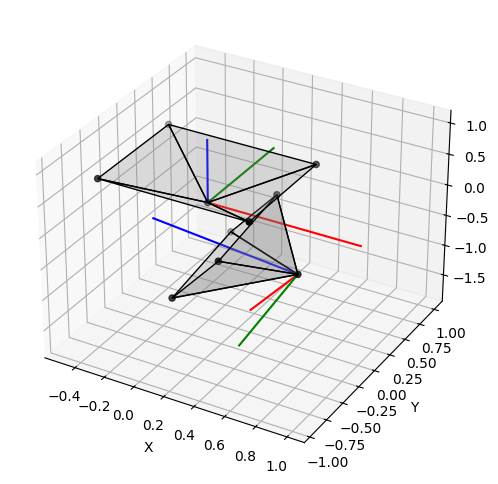

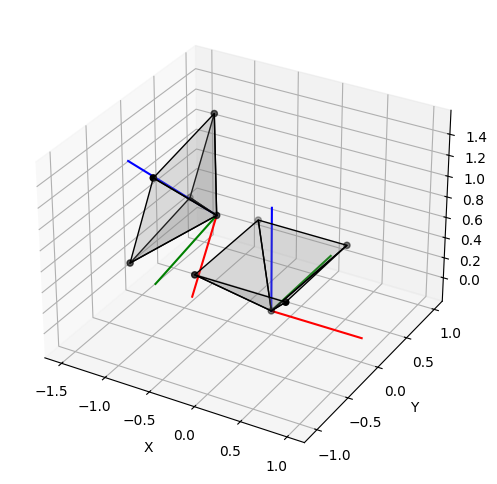

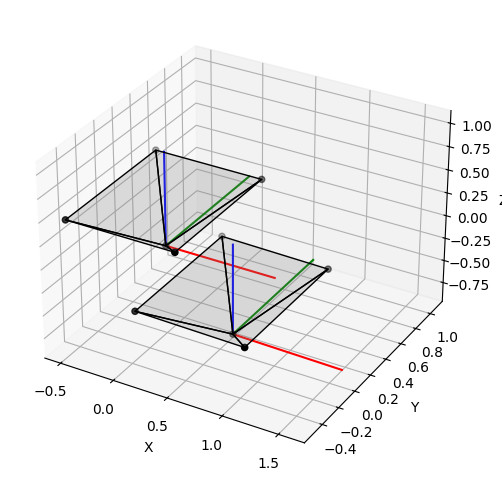

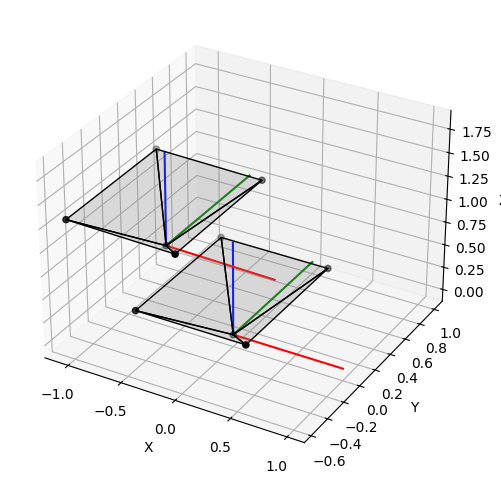

In [ ]:
def PlotCamera(R,t,ax,scale=.5,depth=.5,faceColor='grey'):
    C = -t #camera center (in world coordinate system)

    #Generating camera coordinate axes
    axes = np.zeros((3,6))
    axes[0,1], axes[1,3],axes[2,5] = 1,1,1

    #Transforming to world coordinate system
    axes = R.T.dot(axes)+C[:,np.newaxis]

    #Plotting axes
    ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
    ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
    ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')

    #generating 5 corners of camera polygon
    pt1 = np.array([[0,0,0]]).T #camera centre
    pt2 = np.array([[scale,-scale,depth]]).T #upper right
    pt3 = np.array([[scale,scale,depth]]).T #lower right
    pt4 = np.array([[-scale,-scale,depth]]).T #upper left
    pt5 = np.array([[-scale,scale,depth]]).T #lower left
    pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1)

    #Transforming to world-coordinate system
    pts = R.T.dot(pts)+C[:,np.newaxis]
    ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')

    #Generating a list of vertices to be connected in polygon
    verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
            [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]

    #Generating a polygon now..
    ax.add_collection3d(Poly3DCollection(verts, facecolors=faceColor,
                                         linewidths=1, edgecolors='k', alpha=.25))

for R_ in [R1,R2]:
    for t_ in [t,-t]:

        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
        PlotCamera(R_,t_[:,0],ax)

# 3D Scene Estimations

## Triangulation: DLT Method

In [ ]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t,triangulateFunc):
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]

    pts4d = triangulateFunc(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]

    return pts3d

def Triangulate(P1,P2,img1pts,img2pts):

    img1pts,img2pts = img1pts.T, img2pts.T
    if img1pts.shape[1]==2:
        #converting to homogenous coordinates if not already
        img1pts = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
        img2pts = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    out = np.zeros((img1pts.shape[0],4))

    for i,(img1pt, img2pt) in enumerate(zip(img1pts,img2pts)):
        img1pt_cross, img2pt_cross = Vec2Skew(img1pt), Vec2Skew(img2pt)

        A = []
        A.append(img1pt_cross.dot(P1))
        A.append(img2pt_cross.dot(P2))

        A = np.concatenate(A,axis=0)

        u,s,v = np.linalg.svd(A)
        out[i,:] = v[-1,:]

    return out.T

def Vec2Skew(vec):
    return np.array([[0,-vec[2],vec[1]],[vec[2],0,-vec[0]],[-vec[1],vec[0],0]])

In [ ]:
pts3dgt = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints)
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,Triangulate)

In [ ]:
print(pts3dgt[:5])

print(pts3d[:5])
#np.testing.assert_allclose(pts3d,pts3dgt,rtol=1e-7,atol=1e-3)

[[  -6.77481703   22.69042432 -127.88196023]
 [   4.21835376    0.34559283  -34.5688348 ]
 [   7.83987729   14.48019158  -41.28043032]
 [   8.12577571   13.94871947  -40.80851833]
 [   6.21222296   10.20513218  -39.07667452]]
[[  -6.86028987   22.96308451 -129.41713464]
 [   4.22030118    0.34574876  -34.585234  ]
 [   7.83860182   14.47794205  -41.27394433]
 [   8.11765578   13.93448393  -40.76706017]
 [   6.18383604   10.15655136  -38.89184682]]


In [ ]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t,cv2.triangulatePoints))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t,cv2.triangulatePoints))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t,cv2.triangulatePoints))

## 3.1. Triangulation: DLT Method

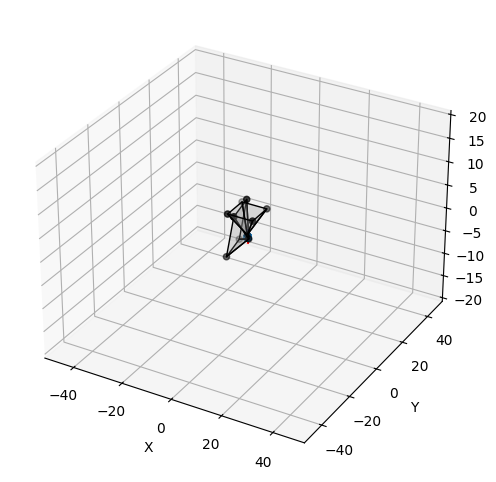

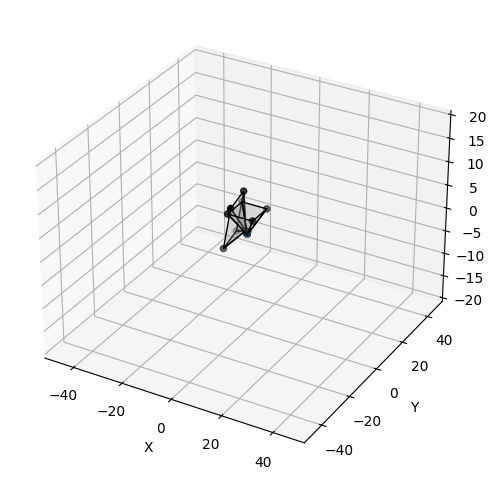

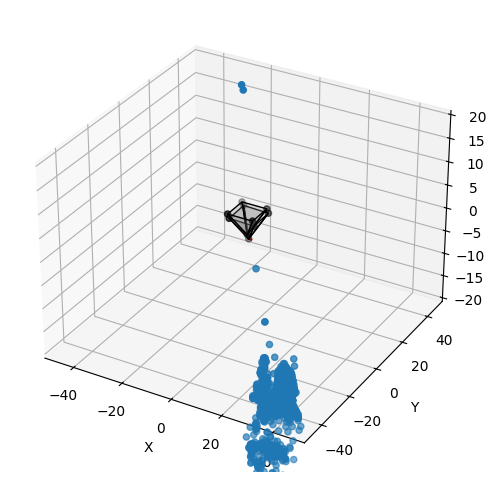

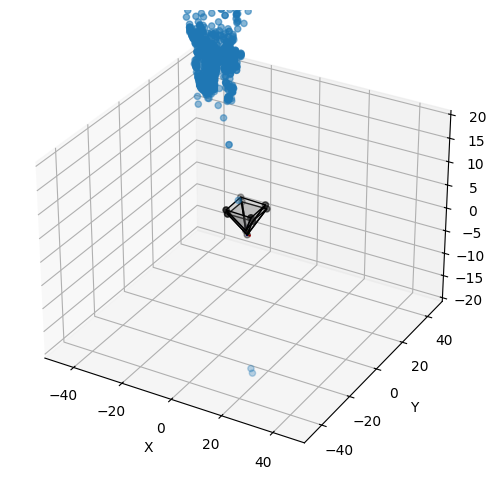

In [ ]:
for cs in configSet:
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)

## Checking for chierality condition

In [ ]:
_,Rgt,tgt,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)

In [ ]:
def DisambiguateCameraPose(configSet):
    maxfrontpts = -1
    bestIndex = -1  # To store the index of the best configuration
    bestConfig = None  # To store the best configuration set entry

    for idx, (R, t, pts3d) in enumerate(configSet):
        count = CountFrontOfBothCameras(pts3d, R, t)

        if count > maxfrontpts:
            maxfrontpts = count
            bestR, bestt = R, t
            bestIndex = idx
            bestConfig = (R, t, pts3d)

    return bestR, bestt, maxfrontpts, bestIndex, bestConfig

def CountFrontOfBothCameras(X, R, t):
    isfrontcam1 = X[:, -1] > 0
    isfrontcam2 = TransformCoordPts(X, R, t)[:, -1] > 0

    return np.sum(isfrontcam1 & isfrontcam2)

def TransformCoordPts(X,R,t):
    return (R.dot(X.T)+t).T

# Assuming configSet is already defined
R, t, count, bestIndex, bestConfig = DisambiguateCameraPose(configSet)

print(f"Best Camera Pose Index: {bestIndex}")

Best Camera Pose Index: 3


In [ ]:
print(Rgt)
print(R)
print(tgt)
print(t)
np.testing.assert_allclose(R,Rgt,rtol=1e-7,atol=1e-4)
np.testing.assert_allclose(t,tgt,rtol=1e-7,atol=1e-4)

[[ 0.99986212 -0.00595738 -0.01549984]
 [ 0.00620368  0.99985448  0.01589128]
 [ 0.01540291 -0.01598525  0.99975358]]
[[ 0.99986212 -0.00595738 -0.01549984]
 [ 0.00620368  0.99985448  0.01589128]
 [ 0.01540291 -0.01598525  0.99975358]]
[[ 0.57627215]
 [ 0.05451732]
 [-0.81543747]]
[[ 0.57627215]
 [ 0.05451732]
 [-0.81543747]]


## Visualizing Point Cloud Output

In [ ]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R,t,cv2.triangulatePoints)
def pts2ply(pts,filename='out.ply'):
    f = open(filename,'w')
    f.write('ply\n')
    f.write('format ascii 1.0\n')
    f.write('element vertex {}\n'.format(pts.shape[0]))

    f.write('property float x\n')
    f.write('property float y\n')
    f.write('property float z\n')

    f.write('property uchar red\n')
    f.write('property uchar green\n')
    f.write('property uchar blue\n')

    f.write('end_header\n')

    for pt in pts:
        f.write('{} {} {} 255 255 255\n'.format(pt[0],pt[1],pt[2]))
    f.close()

pts2ply(pts3d,'hive_2view.ply')

# Reprojection Error: Evaluation

## Computation

In [ ]:
def ComputeReprojections(X,R,t,K):
    """
    X: (n,3) 3D triangulated points in world coordinate system
    R: (3,3) Rotation Matrix to convert from world to camera coordinate system
    t: (3,1) Translation vector (from camera's origin to world's origin)
    K: (3,3) Camera calibration matrix

    out: (n,2) Projected points into image plane"""
    outh = K.dot(R.dot(X.T) + t )
    out = cv2.convertPointsFromHomogeneous(outh.T)[:,0,:]
    return out

def ComputeReprojectionError(x2d, x2dreproj):
    """
    x2d: (n,2) Ground truth indices of SIFT features
    x2dreproj: (n,2) Reprojected indices of triangulated points of SIFT features

    out: (scalar) Mean reprojection error of points"""
    return np.mean(np.sqrt(np.sum((x2d-x2dreproj)**2,axis=-1)))

img1ptsReproj = ComputeReprojections(pts3d,np.eye(3,3),np.zeros((3,1)),K)
img2ptsReproj = ComputeReprojections(pts3d,R,t,K)

In [ ]:
err2 = ComputeReprojectionError(img2pts[mask], img2ptsReproj)
err1 = ComputeReprojectionError(img1pts[mask], img1ptsReproj)

err1, err2

(4.051308231761682, 4.141631450340079)

## Computation

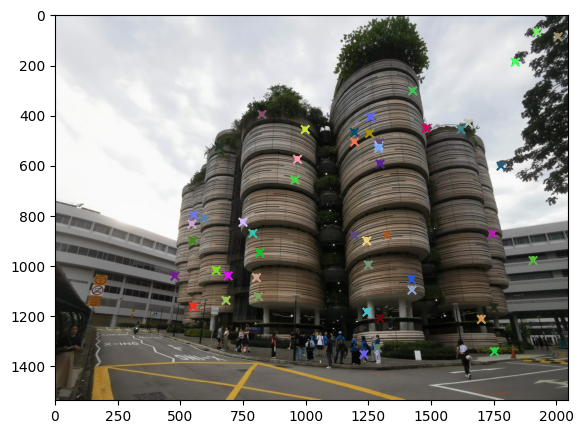

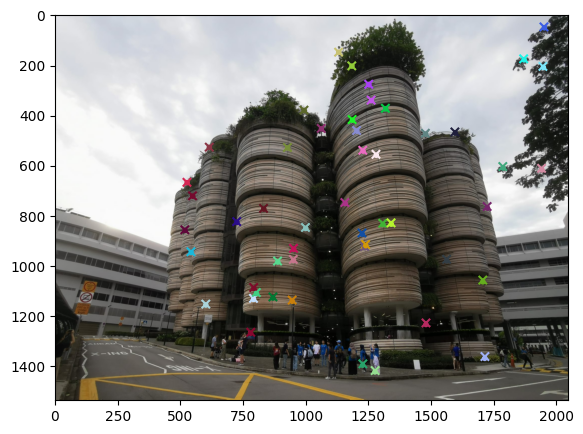

In [ ]:
def DrawCorrespondences(img, ptsTrue, ptsReproj, ax, drawOnly=50):
    ax.imshow(img)

    randidx = np.random.choice(ptsTrue.shape[0],size=(drawOnly,),replace=False)
    ptsTrue_, ptsReproj_ = ptsTrue[randidx], ptsReproj[randidx]

    colors = colors=np.random.rand(drawOnly,3)

    ax.scatter(ptsTrue_[:,0],ptsTrue_[:,1],marker='x',c=colors)
    ax.scatter(ptsReproj_[:,0],ptsReproj_[:,1],marker='.',c=colors)

fig,ax=plt.subplots(figsize=(9,5))
DrawCorrespondences(img1,img1pts[mask],img1ptsReproj,ax)

fig,ax=plt.subplots(figsize=(9,5))
DrawCorrespondences(img2,img2pts[mask],img2ptsReproj,ax)

# Perspective-n-Point Algorithm: New Camera Registration

## Reading third image and 2D-3D Matching using SIFT

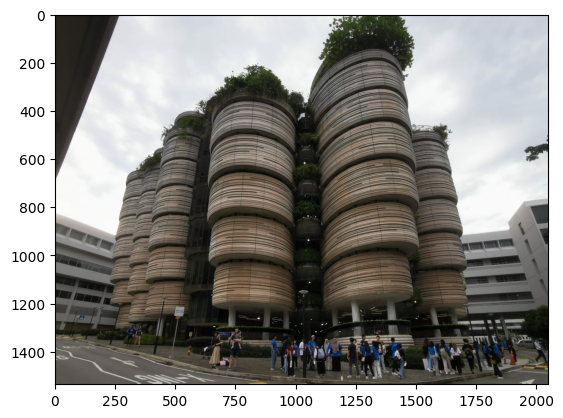

In [ ]:
img3 = cv2.imread('/content/drive/MyDrive/Structure7/03.jpeg')
img3 = img3[:,:,::-1]
surfer=cv2.SIFT_create()
kp3, desc3 = surfer.detectAndCompute(img3,None)

plt.figure()
plt.imshow(img3)

def Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d):
    #Picking only those descriptors for which 3D point is available
    desc1_3D = desc1[img1idx][mask]
    desc2_3D = desc2[img2idx][mask]

    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(desc3, np.concatenate((desc1_3D,desc2_3D),axis=0))

    #Filtering out matched 2D keypoints from new view
    img3idx = np.array([m.queryIdx for m in matches])
    kp3_ = (np.array(kp3))[img3idx]
    img3pts = np.array([kp.pt for kp in kp3_])

    #Filtering out matched 3D already triangulated points
    pts3didx = np.array([m.trainIdx for m in matches])
    pts3didx[pts3didx >= pts3d.shape[0]] = pts3didx[pts3didx >= pts3d.shape[0]] - pts3d.shape[0]
    pts3d_ = pts3d[pts3didx]

    return img3pts, pts3d_

img3pts,pts3dpts = Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d)

## Perspective-n-Point (PnP) Algorithm

### Least Squares Solution

In [ ]:
def LinearPnP(X, x, K):
    xh = np.hstack((x, np.ones((x.shape[0],1))))
    Xh = np.hstack((X, np.ones((X.shape[0],1))))
    xc = np.linalg.inv(K).dot(xh.T).T

    A = np.zeros((X.shape[0]*3,12))

    for i in range(X.shape[0]):
        A[i*3,:] = np.concatenate((np.zeros((4,)), -Xh[i,:], xc[i,1]*Xh[i,:]))
        A[i*3+1,:] = np.concatenate((Xh[i,:], np.zeros((4,)), -xc[i,0]*Xh[i,:]))
        A[i*3+2,:] = np.concatenate((-xc[i,1]*Xh[i,:], xc[i,0]*Xh[i,:], np.zeros((4,))))

    u,s,v = np.linalg.svd(A)
    P = v[-1,:].reshape((4,3),order='F').T
    R, t = P[:,:3], P[:,-1]

    u,s,v = np.linalg.svd(R)
    R = u.dot(v)
    t = t/s[0]

    if np.linalg.det(u.dot(v)) < 0:
        R = R*-1
        t = t*-1

    C = -R.T.dot(t)

    return R, t

Rtest,ttest=LinearPnP(pts3dpts,img3pts,K)

### RANSAC

In [ ]:
retval,Rvec,tnew,mask3gt = cv2.solvePnPRansac(pts3dpts[:,np.newaxis],img3pts[:,np.newaxis],
                                            K,None,confidence=.99,flags=cv2.SOLVEPNP_DLS)
Rnew,_=cv2.Rodrigues(Rvec)
tnew = tnew[:,0]

## Visualizations

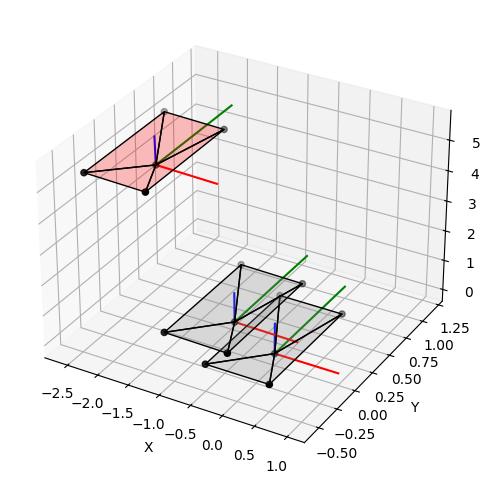

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
PlotCamera(R,t[:,0],ax)
PlotCamera(Rnew,tnew,ax,faceColor='red')

# Re-triangulation

In [ ]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t,triangulateFunc,Rbase=None,tbase=None):

    if Rbase is None:
        Rbase = np.eye((3,3))
    if tbase is None:
        tbase = np.zeros((3,1))

    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]

    print(Rbase.shape, tbase.shape, R.shape, t.shape)
    pts4d = triangulateFunc(np.hstack((Rbase,tbase)),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]

    return pts3d

kpNew, descNew = kp3, desc3

kpOld,descOld = kp1,desc1
ROld, tOld = np.eye(3), np.zeros((3,1))

accPts = []
for (ROld, tOld, kpOld, descOld) in [(np.eye(3),np.zeros((3,1)), kp1,desc1),(R,t,kp2,desc2)]:

    #Matching between old view and newly registered view..
    print('[Info]: Feature Matching..')
    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(descOld, desc3)
    matches = sorted(matches, key = lambda x:x.distance)
    imgOldPts, imgNewPts, _, _ = GetAlignedMatches(kpOld,descOld,kpNew,
                                                          descNew,matches)

    #Pruning the matches using fundamental matrix..
    print('[Info]: Pruning the Matches..')
    F,maskt=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC,ransacReprojThreshold=.1,confidence=.99)
    maskt = maskt.flatten().astype(bool)
    imgOldPts=imgOldPts[maskt]
    imgNewPts=imgNewPts[maskt]

    #Triangulating new points
    print('[Info]: Triangulating..')
    newPts = GetTriangulatedPts(imgOldPts,imgNewPts, K, Rnew,tnew[:,np.newaxis],cv2.triangulatePoints,ROld,tOld)

    #Adding newly triangulated points to the collection
    accPts.append(newPts)

[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)
[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
(3, 3) (3, 1) (3, 3) (3, 1)


In [ ]:
#Adding the original 2-view-sfm point cloud and saving the whole collection
accPts.append(pts3d)

def pts2ply(pts,filename='out.ply'):
    f = open(filename,'w')
    f.write('ply\n')
    f.write('format ascii 1.0\n')
    f.write('element vertex {}\n'.format(pts.shape[0]))

    f.write('property float x\n')
    f.write('property float y\n')
    f.write('property float z\n')

    f.write('property uchar red\n')
    f.write('property uchar green\n')
    f.write('property uchar blue\n')

    f.write('end_header\n')

    for pt in pts:
        f.write('{} {} {} 255 255 255\n'.format(pt[0],pt[1],pt[2]))
    f.close()

pts2ply(np.concatenate((accPts),axis=0),'hive_3view.ply')

